In [1]:
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG
from castle.algorithms import DirectLiNGAM
from castle.algorithms import ICALiNGAM

import networkx as nx
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

2023-11-16 22:17:38,487 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-11-16 22:17:39,078 - /home/flav/anaconda3/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('messageReceived', 'bandwidth')
                         ])

In [3]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlaz

In [4]:
#Treat dataset

#Import data 
data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['identifier', 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

X = consolidated.to_numpy()
print(X)

[[8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  1.000e+00 2.149e+03 1.262e+06 1.830e+03 1.682e+06 1.537e+03 1.250e+02
  1.700e+01 1.098e+05 0.000e+00]
 [8.000e+00 6.000e+00 1.200e+01 4.000e+00 8.000e+00 2.000e+00 2.500e-01
  3.000e+00 2.160e+03 1.220e+06 1.606e+03 1.844e+06 2.137e+03 0.000e+00
  1.000e+00 4.868e+03 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  1.000e+00 2.009e+03 9.919e+05 1.300e+03 1.428e+06 2.138e+03 0.000e+00
  0.000e+00 7.920e+02 0.000e+00]
 [1.600e+01 8.000e+00 2.000e+01 1.600e+01 8.000e+00 4.000e+00 5.000e-01
  5.000e-01 6.675e+03 3.889e+05 6.215e+02 7.629e+05 1.387e+03 1.350e+02
  1.200e+01 7.145e+04 0.000e+00]
 [6.000e+00 4.000e+00 8.000e+00 2.000e+00 2.000e+00 2.000e+00 2.500e-01
  1.000e+00 3.089e+03 8.594e+05 1.363e+03 1.778e+06 1.469e+03 3.080e+02
  4.600e+01 1.418e+05 0.000e+00]
 [6.000e+00 4.000e+00 8.000e+00 2.000e+00 2.000e+00 4.000e+00 2.500e-01
  5.000e-01 2.097e+03 3.912e+05 5.922e+02 8

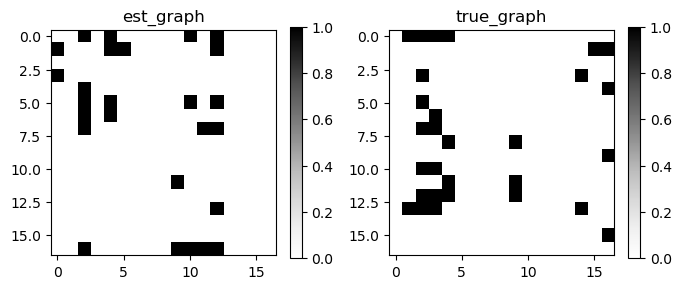

{'fdr': 0.8077, 'tpr': 0.1724, 'fpr': 0.1963, 'shd': 42, 'nnz': 26, 'precision': 0.1923, 'recall': 0.1724, 'F1': 0.1818, 'gscore': 0.0}


In [5]:
g = DirectLiNGAM()
g.learn(X)

# plot est_dag and true_dag
GraphDAG(g.causal_matrix, true_causal_matrix)#, true_dag)

# calculate accuracy
met = MetricsDAG(g.causal_matrix, true_causal_matrix)#, true_dag)
print(met.metrics)

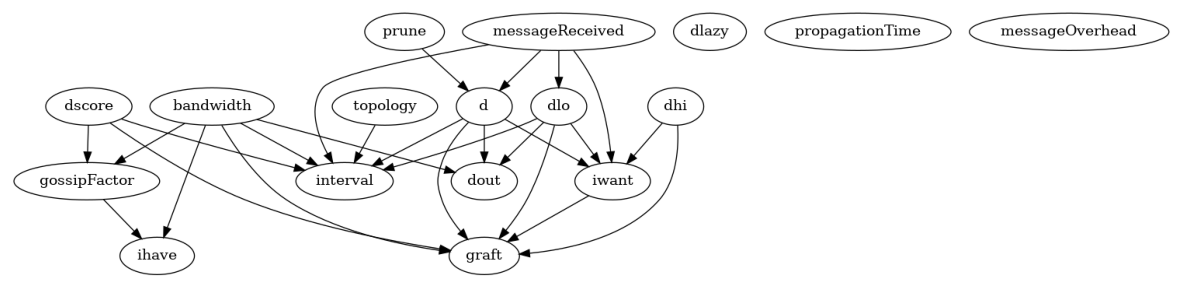

In [6]:
learned_causal_graph =  nx.from_numpy_array(g.causal_matrix,  create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

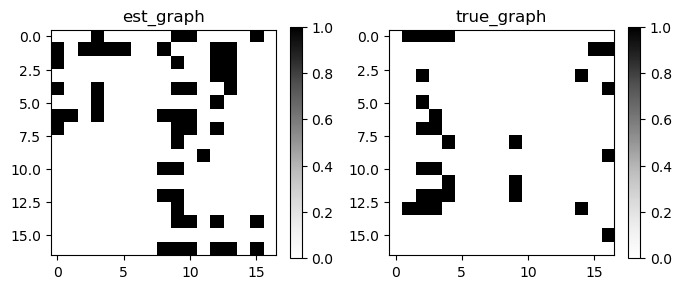

{'fdr': 0.8077, 'tpr': 0.1724, 'fpr': 0.1963, 'shd': 42, 'nnz': 26, 'precision': 0.1923, 'recall': 0.1724, 'F1': 0.1818, 'gscore': 0.0}


In [7]:
g2 = ICALiNGAM()
g2.learn(X)

# plot est_dag and true_dag
GraphDAG(g2.causal_matrix, true_causal_matrix)

# calculate accuracy
met = MetricsDAG(g.causal_matrix, true_causal_matrix)
print(met.metrics)

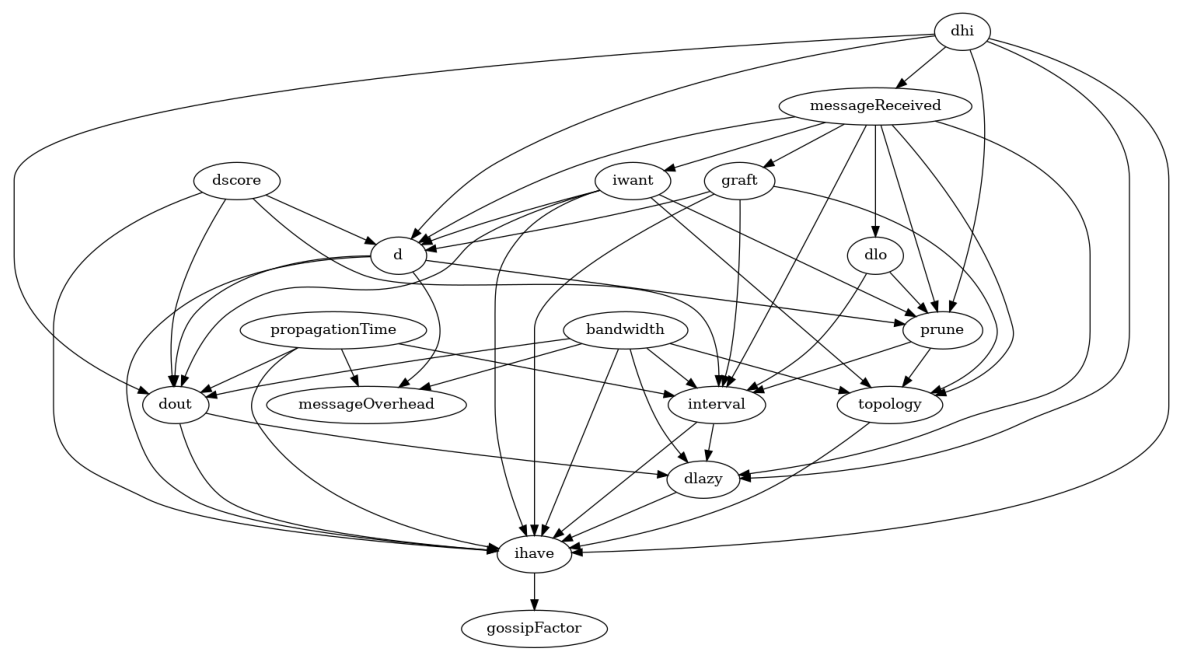

In [24]:
learned_causal_graph =  nx.from_numpy_array(g2.causal_matrix,  create_using=nx.DiGraph)

mapping = {0:'d', 1:'messageReceived', 2:'graft', 3:'prune', 4:'iwant', 5:'dlo', 6:'dhi', 7:'dscore', 8:'dlazy', 9:'ihave', 10:'dout', 11:'gossipFactor', 12:'interval', 13:'topology', 14:'propagationTime', 15:'messageOverhead', 16:'bandwidth'}
# nx.set_node_attributes(learned_causal_graph, labels, "name")
H = nx.relabel_nodes(learned_causal_graph, mapping)

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

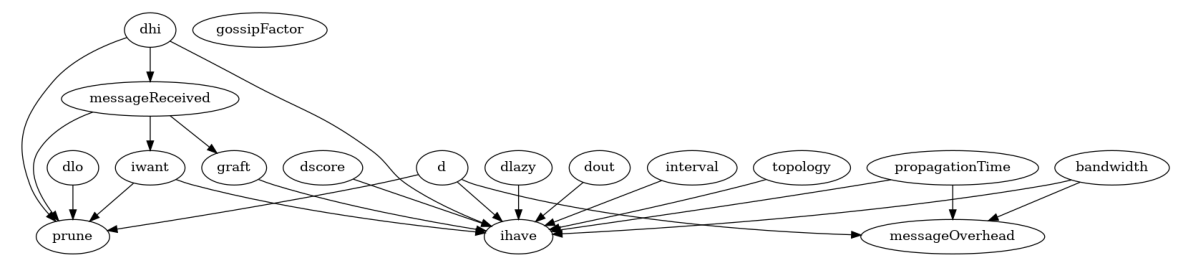

In [25]:
#Remove edges for dowhy analysis

H.remove_edge('dhi', 'd')
H.remove_edge('graft', 'd')
H.remove_edge('propagationTime', 'dout')
H.remove_edge('bandwidth', 'dout')
H.remove_edge('d', 'dout')
H.remove_edge('dscore', 'dout')
H.remove_edge('dhi', 'dout')
H.remove_edge('interval', 'dlazy')
H.remove_edge('bandwidth', 'dlazy')
H.remove_edge('dout', 'dlazy')
H.remove_edge('messageReceived', 'dlazy')
H.remove_edge('dhi', 'dlazy')
H.remove_edge('ihave', 'gossipFactor')
H.remove_edge('dlo', 'interval')
H.remove_edge('prune', 'interval')
H.remove_edge('dscore', 'interval')
H.remove_edge('messageReceived', 'interval')
H.remove_edge('dscore', 'd')
H.remove_edge('bandwidth', 'interval')
H.remove_edge('graft', 'interval')
H.remove_edge('iwant', 'topology')
H.remove_edge('prune', 'topology')
H.remove_edge('messageReceived', 'topology')
H.remove_edge('graft', 'topology')
H.remove_edge('bandwidth', 'topology')
H.remove_edge('propagationTime', 'interval')
H.remove_edge('iwant', 'd')
H.remove_edge('messageReceived', 'dlo')
H.remove_edge('messageReceived', 'd')
H.remove_edge('iwant', 'dout')

fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H)#, figure_size=[15, 10])

In [34]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(H)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, consolidated)

In [35]:
#Fit model to data
gcm.fit(scm, consolidated)

Fitting causal mechanism of node bandwidth: 100%|██████████| 17/17 [00:00<00:00, 117.89it/s]    


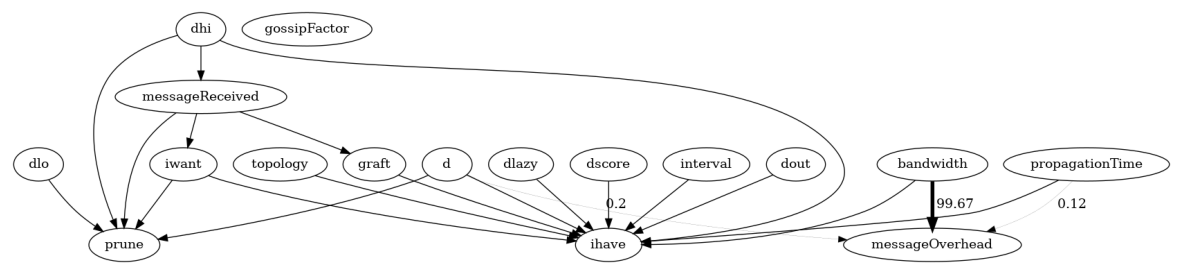

In [37]:
#Key factors influencing MessageOverhead?

def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='messageOverhead')


fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Evaluate set function: 16it [00:00, 69.97it/s]


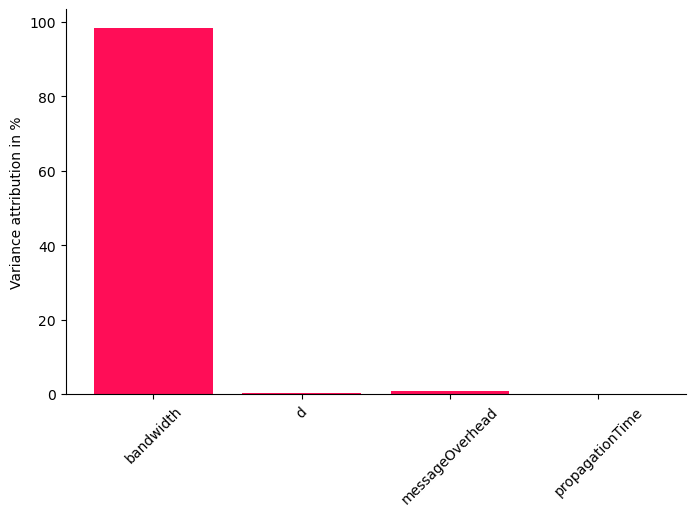

In [38]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='messageOverhead', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

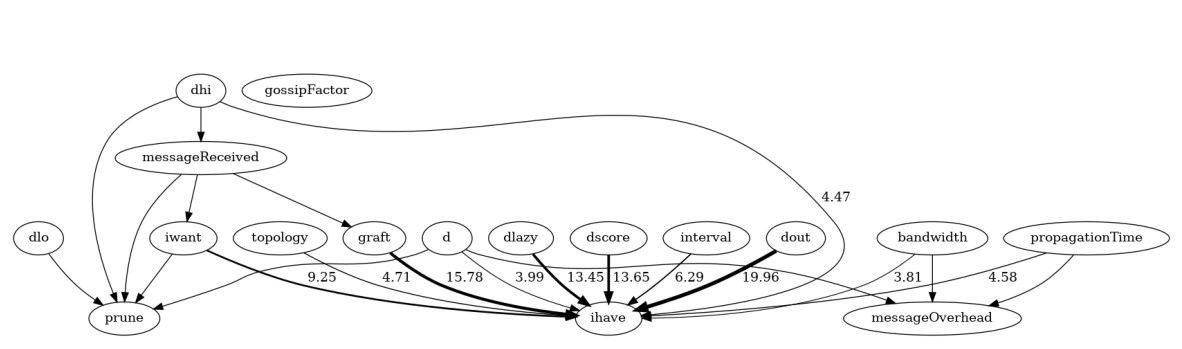

In [39]:
#Key factors influencing ihave?

def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='ihave')


fig, ax = plt.subplots(figsize=(15,20)) 
gcm.util.plot(H, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Estimating Shapley Values. Average change of Shapley values in run 47 (235 evaluated permutations): 2.3133136586691307%: 100%|██████████| 1/1 [01:29<00:00, 89.98s/it]


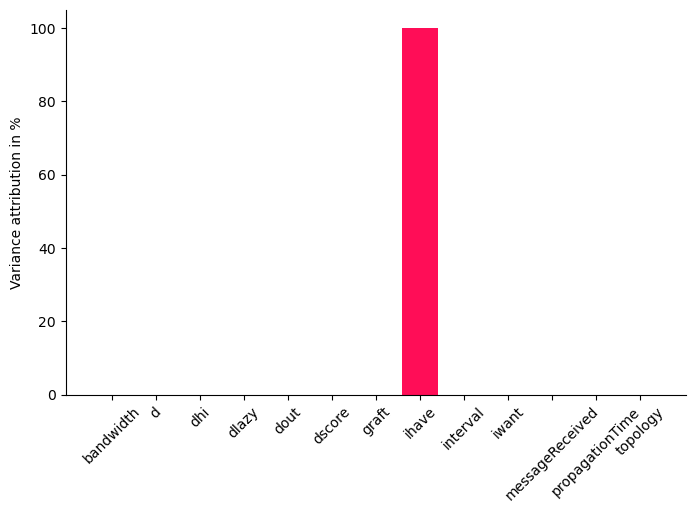

In [40]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='ihave', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')